In [17]:
import pandas as pd

data = pd.read_csv('../../data/processed/import_declarations_intermax_daily.csv')

data['Date'] = pd.to_datetime(data['Date'])
data

,Date,Abgabe
0,2017-01-02,439.79
1,2017-01-03,2107.94
2,2017-01-04,215.37
3,2017-01-05,0.00
4,2017-01-06,0.00
...,...,...
1040,2019-11-08,1265.71
1041,2019-11-09,0.00
1042,2019-11-10,0.00
1043,2019-11-11,0.00


In [18]:
data['Abgabe_rolling'] = data['Abgabe'].rolling(window=30).mean()

data.Abgabe_rolling.dropna()

29       414.082333
30       399.422667
31       329.158000
32       321.979000
33       321.979000
           ...     
1040    1592.881333
1041    1561.454000
1042    1429.151333
1043    1429.151333
1044    1441.451333
Name: Abgabe_rolling, Length: 1016, dtype: float64

In [19]:
from statsmodels.tsa.tsatools import add_lag

num_lags = 3

lagged_feature = add_lag(data.Abgabe_rolling, lags=2, drop=False, insert=True)
#for i in range(1, num_lags + 1):
#    lagged_features[f'Abgabe_lag_{i}'] = data['Abgabe_avg'].shift(i)
lagged_features = pd.DataFrame(lagged_feature)

new_columns = ['Lag_1', 'Lag_2', 'Lag_3']
lagged_features.columns = new_columns


df_with_lags = pd.concat([data, lagged_features], axis=1)
df_with_lags = df_with_lags.dropna(subset='Abgabe_rolling')
df_with_lags

,Date,Abgabe,Abgabe_rolling,Lag_1,Lag_2,Lag_3
29,2017-01-31,1045.81,414.082333,329.158000,399.422667,414.082333
30,2017-02-01,0.00,399.422667,321.979000,329.158000,399.422667
31,2017-02-02,0.00,329.158000,321.979000,321.979000,329.158000
32,2017-02-03,0.00,321.979000,321.979000,321.979000,321.979000
33,2017-02-04,0.00,321.979000,360.664667,321.979000,321.979000
...,...,...,...,...,...,...
1040,2019-11-08,1265.71,1592.881333,1429.151333,1561.454000,1592.881333
1041,2019-11-09,0.00,1561.454000,1429.151333,1429.151333,1561.454000
1042,2019-11-10,0.00,1429.151333,1441.451333,1429.151333,1429.151333
1043,2019-11-11,0.00,1429.151333,NaN,NaN,NaN


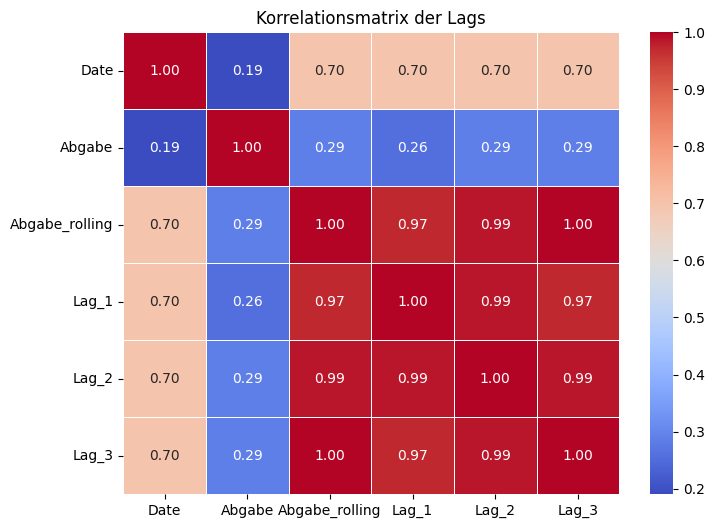

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df_with_lags.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsmatrix der Lags')
plt.show()

In [21]:
from data_preperation import split_data

train, test = split_data(data=df_with_lags, test_split=0.66)

train = train.dropna()

train: 670 , test: 346


In [22]:
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day

test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day

/tmp/ipykernel_297843/1913794.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Year'] = test['Date'].dt.year
/tmp/ipykernel_297843/1913794.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Month'] = test['Date'].dt.month
/tmp/ipykernel_297843/1913794.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [23]:
X = train[['Year', 'Month', 'Day', 'Lag_1', 'Lag_2', 'Lag_3']]
y = train['Abgabe_rolling']

print(X.info(), y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 670 entries, 29 to 698
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    670 non-null    int32  
 1   Month   670 non-null    int32  
 2   Day     670 non-null    int32  
 3   Lag_1   670 non-null    float64
 4   Lag_2   670 non-null    float64
 5   Lag_3   670 non-null    float64
dtypes: float64(3), int32(3)
memory usage: 28.8 KB
<class 'pandas.core.series.Series'>
Index: 670 entries, 29 to 698
Series name: Abgabe_rolling
Non-Null Count  Dtype  
--------------  -----  
670 non-null    float64
dtypes: float64(1)
memory usage: 10.5 KB
None None


In [24]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=120)
model.fit(X, y)

RandomForestRegressor(random_state=120)

In [25]:
median_values = test[['Lag_1', 'Lag_2', 'Lag_3']].median()

# Fill missing values in lag columns with respective medians
test[['Lag_1', 'Lag_2', 'Lag_3']] = test[['Lag_1', 'Lag_2', 'Lag_3']].fillna(median_values)

/tmp/ipykernel_297843/1706878876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['Lag_1', 'Lag_2', 'Lag_3']] = test[['Lag_1', 'Lag_2', 'Lag_3']].fillna(median_values)


In [26]:
y_pred = pd.Series(model.predict(test[['Year', 'Month', 'Day', 'Lag_1', 'Lag_2', 'Lag_3']]), index=test['Date'])

y_pred

Date
2018-12-02     737.025923
2018-12-03     743.527343
2018-12-04     745.356433
2018-12-05     745.590220
2018-12-06     777.197603
                 ...     
2019-11-08    1641.407427
2019-11-09    1527.279263
2019-11-10    1439.198827
2019-11-11    1526.398057
2019-11-12    1526.398057
Length: 346, dtype: float64

In [27]:
from data_preperation import get_validation_matrix

y_pred_validation = y_pred.reset_index(drop=True)
test_validation = test.Abgabe_rolling.reset_index(drop=True)

validation_results = get_validation_matrix(y_pred, test['Abgabe_rolling'], train.Abgabe_rolling)
validation_results['name'] = 'RandomForrests'
validation_results

{'MAE': 18.20660265895981,
 'MSE': 776.9049964924932,
 'meanMASE': 0.45305547471800667,
 'r2': 0.9978030783952542,
 'Forecast Bias': nan,
 'Forecast Accuracy (%)': 220.72352190919347,
 'name': 'RandomForrests'}

In [28]:
from data_preperation import save_metrics_to_csv

save_metrics_to_csv(validation_results)

Metrics saved to metrics.csv


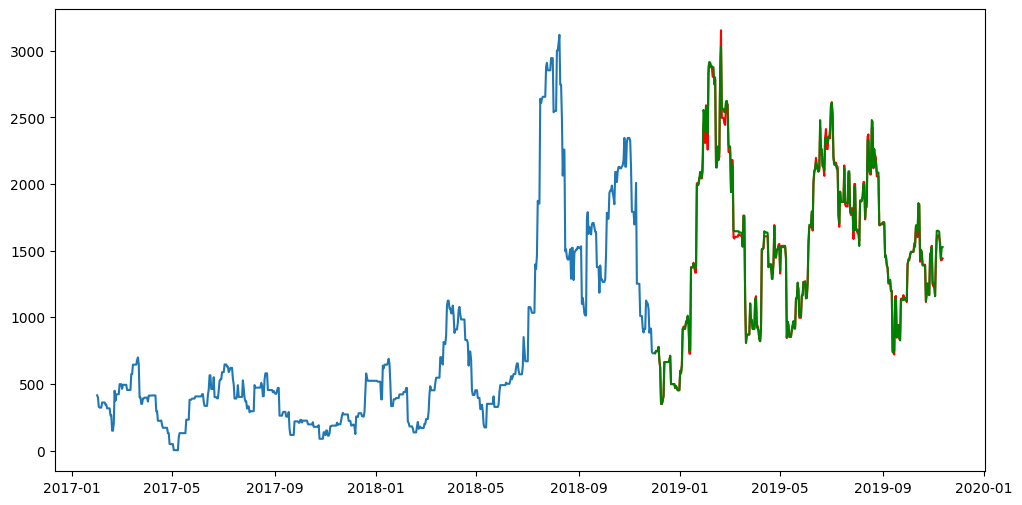

In [29]:
test_indexed = test.set_index('Date')

plt.figure(figsize=(12, 6))
plt.plot(train.Date, train.Abgabe_rolling)
plt.plot(test_indexed.index, test_indexed['Abgabe_rolling'], label='Actual', color='red')
plt.plot(test_indexed.index, y_pred, color="green")

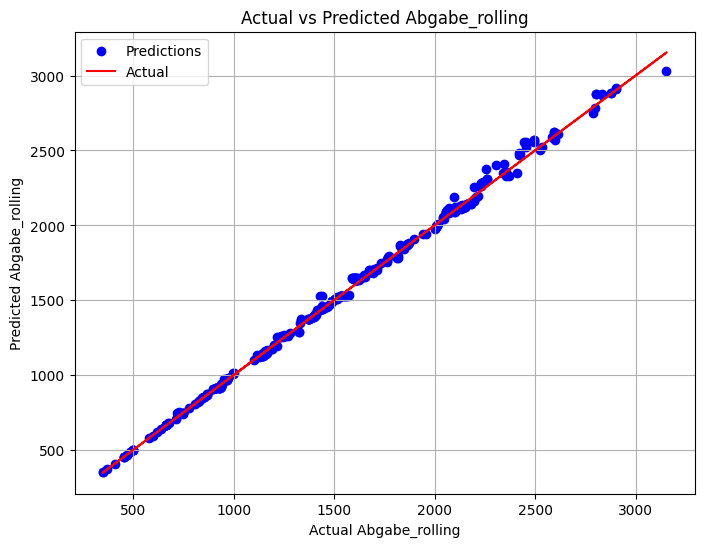

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(test['Abgabe_rolling'], y_pred, color='blue', label='Predictions')
plt.plot(test['Abgabe_rolling'], test['Abgabe_rolling'], color='red', label='Actual')  # Plotting the identity line
plt.title('Actual vs Predicted Abgabe_rolling')
plt.xlabel('Actual Abgabe_rolling')
plt.ylabel('Predicted Abgabe_rolling')
plt.legend()
plt.grid(True)
plt.show()